 # Claim Analysis and Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patheffects import withStroke
import plot_info

In [2]:
# Load data
df = pd.read_csv('preprocessed_data/claims_db_truncated_for_llm.csv')
df["assessment_type"].unique()

array([nan, 'Not assessed', 'Verified', 'Mixed', 'Unchallenged',
       'Unchallenged, logically consistent', 'Partially verified',
       'Challenged', 'Unchallenged, logically inconsistent',
       'Challenged by reproducibility project',
       'Challenged by same authors', 'Verified by same authors',
       'Verified by reproducibility project', 'Reproduction in progress'],
      dtype=object)

In [3]:
df[["assertion_type"]].value_counts()

assertion_type    
assessment            6423
evidence              3886
major_claim           1006
minor_claim            590
main_claim             400
reference              399
method                 393
comment                148
additional_context      54
Name: count, dtype: int64

In [4]:
major_claims_df = df[df['assertion_type'] == 'major_claim']
print(len(major_claims_df))
major_claims_df

1006


,id,content,article_id,rank,pmid,authors_txt,title,pmid_article,volume,issue,...,impact_factor,first_author_extracted,last_author_extracted,primary_affiliation,country,assertion_type,label,is_assessed,assessment_type,rank_assessment_type
8,577,#gene:FBgn0000279 is...,3103.0,2,NaN,Tryselius Y;Samakovl...,"CecC, a cecropin gen...",1740152.0,204,1,...,5.4,Tryselius Y,Hultmark D,Department of Microb...,Sweden,major_claim,Major claim,True,Verified,1.0
30,5845,Hemocyte proliferati...,2204.0,3,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,11.1,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0
31,5841,The Ras/MAPK pathway...,2204.0,1,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,11.1,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0
37,5843,The JAK/STAT and JNK...,2204.0,2,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,11.1,Zettervall CJ,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0
110,545,#gene:FBgn0035976 fu...,2520.0,2,NaN,Gottar M;Gobert V;Mi...,The Drosophila immun...,11912488.0,416,6881,...,64.8,Gottar M,Royet J,UPR 9022 du Centre N...,France,major_claim,Major claim,True,Verified,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13261,9082,Ehrlichia chaffeensi...,1593.0,1,NaN,Luce-Fedrow A;Von Oh...,Ehrlichia chaffeensi...,19687202.0,77,11,...,3.1,Luce-Fedrow A,Chapes SK,Kansas State Univers...,USA,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0
13264,9728,B. bassiana inhibits...,1532.0,2,NaN,Matskevich AA;Quinti...,The Drosophila PRR G...,20201042.0,40,5,...,5.4,Matskevich AA,Ferrandon D,Equipe Fondation Rec...,France,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0
13270,1769,A polyclonal antibod...,3004.0,2,NaN,Georgel P;Kappler C;...,Drosophila immunity....,7537872.0,23,7,...,14.9,Georgel P,Hoffmann JA,Institut de Biologie...,France,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0
13273,2906,A pathway in additio...,2874.0,3,NaN,Wu LP;Anderson KV,Regulated nuclear im...,9510254.0,392,6671,...,64.8,Wu LP,Anderson KV,Molecular Biology Pr...,USA,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0


In [5]:
major_claims_df[["assessment_type"]].value_counts()

assessment_type                      
Verified                                 559
Unchallenged, logically consistent       111
Unchallenged                             107
Partially verified                        75
Verified by same authors                  44
Challenged by reproducibility project     38
Challenged                                26
Unchallenged, logically inconsistent      22
Mixed                                     12
Verified by reproducibility project        7
Challenged by same authors                 5
Name: count, dtype: int64

In [6]:
# Apply categorizations - using .loc to avoid SettingWithCopyWarning
major_claims_df.loc[:, 'journal_category'] = major_claims_df['impact_factor'].apply(plot_info.categorize_journal)
major_claims_df.loc[:, 'assessment_group'] = major_claims_df['assessment_type'].apply(plot_info.group_assessment)

# Display distribution of journal categories
print(f"Journal Category Distribution:")
print(major_claims_df['journal_category'].value_counts())
print("\nAssessment Group Distribution:")
print(major_claims_df['assessment_group'].value_counts())


Journal Category Distribution:
journal_category
Low Impact         635
High Impact        309
Trophy Journals     62
Name: count, dtype: int64

Assessment Group Distribution:
assessment_group
Verified              610
Unchallenged          240
Partially Verified     75
Challenged             69
Mixed                  12
Name: count, dtype: int64


/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_26863/892573795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_claims_df.loc[:, 'journal_category'] = major_claims_df['impact_factor'].apply(plot_info.categorize_journal)
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_26863/892573795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_claims_df.loc[:, 'assessment_group'] = major_claims_df['assessment_type'].apply(plot_info.group_assessment)


In [7]:
unique_pairs = major_claims_df[["journal_name", "impact_factor"]].drop_duplicates().sort_values("impact_factor", ascending=False)
for index, row in unique_pairs.iterrows():
    # Count occurrences of this journal in major_claims
    count = len(major_claims_df[major_claims_df["journal_name"] == row["journal_name"]])
    print(f"{row['impact_factor']:.1f}\t{row['journal_name']} ({count} claims)")


64.8	Nature (20 claims)
64.5	Cell (15 claims)
56.9	Science (New York, N.Y.) (27 claims)
32.4	Immunity (24 claims)
30.5	Nature immunology (28 claims)
30.3	Cell host & microbe (11 claims)
16.0	Molecular cell (8 claims)
14.9	Nucleic acids research (11 claims)
14.8	Nature protocols (1 claims)
11.8	Developmental cell (24 claims)
11.4	The EMBO journal (56 claims)
11.1	Proceedings of the National Academy of Sciences of the United States of America (119 claims)
10.5	Genes & development (25 claims)
10.3	National Cancer Institute monograph (2 claims)
9.8	PLoS biology (19 claims)
9.3	Experientia (1 claims)
9.2	Current biology : CB (36 claims)
9.1	EMBO reports (31 claims)
7.8	The Journal of cell biology (1 claims)
7.8	The Journal of biophysical and biochemical cytology (2 claims)
7.8	Aging cell (6 claims)
7.0	Molecular & cellular proteomics : MCP (3 claims)
6.9	Journal of experimental botany (2 claims)
6.7	PLoS pathogens (40 claims)
5.8	Microbes and infection (7 claims)
5.6	Journal of molecular bi

In [8]:
major_claims_df

,id,content,article_id,rank,pmid,authors_txt,title,pmid_article,volume,issue,...,last_author_extracted,primary_affiliation,country,assertion_type,label,is_assessed,assessment_type,rank_assessment_type,journal_category,assessment_group
8,577,#gene:FBgn0000279 is...,3103.0,2,NaN,Tryselius Y;Samakovl...,"CecC, a cecropin gen...",1740152.0,204,1,...,Hultmark D,Department of Microb...,Sweden,major_claim,Major claim,True,Verified,1.0,Low Impact,Verified
30,5845,Hemocyte proliferati...,2204.0,3,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
31,5841,The Ras/MAPK pathway...,2204.0,1,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
37,5843,The JAK/STAT and JNK...,2204.0,2,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
110,545,#gene:FBgn0035976 fu...,2520.0,2,NaN,Gottar M;Gobert V;Mi...,The Drosophila immun...,11912488.0,416,6881,...,Royet J,UPR 9022 du Centre N...,France,major_claim,Major claim,True,Verified,1.0,Trophy Journals,Verified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13261,9082,Ehrlichia chaffeensi...,1593.0,1,NaN,Luce-Fedrow A;Von Oh...,Ehrlichia chaffeensi...,19687202.0,77,11,...,Chapes SK,Kansas State Univers...,USA,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0,Low Impact,Unchallenged
13264,9728,B. bassiana inhibits...,1532.0,2,NaN,Matskevich AA;Quinti...,The Drosophila PRR G...,20201042.0,40,5,...,Ferrandon D,Equipe Fondation Rec...,France,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0,Low Impact,Unchallenged
13270,1769,A polyclonal antibod...,3004.0,2,NaN,Georgel P;Kappler C;...,Drosophila immunity....,7537872.0,23,7,...,Hoffmann JA,Institut de Biologie...,France,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0,High Impact,Unchallenged
13273,2906,A pathway in additio...,2874.0,3,NaN,Wu LP;Anderson KV,Regulated nuclear im...,9510254.0,392,6671,...,Anderson KV,Molecular Biology Pr...,USA,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0,Trophy Journals,Unchallenged


In [9]:
major_claims_df[["journal_category", "journal_name"]][major_claims_df["journal_category"] == "Trophy Journals"]["journal_name"].value_counts()

journal_name
Science (New York, N.Y.)    27
Nature                      20
Cell                        15
Name: count, dtype: int64

 ## Plot Functions

 ## Analysis and Visualization

 ### Journal Category Analysis

In [10]:
def create_journal_claims_table(df):
    """
    Create a table with journal name, impact factor, and counts for each claim type
    
    Parameters:
    - df: DataFrame containing the claims data
    
    Returns:
    - A DataFrame with journal information and claim counts
    """
    # Make a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()
    
    # Map detailed assessment types to standardized categories
    df_copy['standard_category'] = df_copy['assessment_type'].map(
        lambda x: plot_info.category_mapping.get(x, x)
    ) # TODO This mapping is not waht shoudl be used for the table
    
    # Group by journal name and impact factor
    grouped = df_copy.groupby(['journal_name', 'impact_factor'])['standard_category'].value_counts().unstack().fillna(0)
    
    # Convert counts to integers
    for col in grouped.columns:
        grouped[col] = grouped[col].astype(int)
    
    # Create a total count column
    grouped['Total'] = grouped.sum(axis=1)
    
    # Sort by impact factor (descending)
    grouped = grouped.sort_values(by='impact_factor', ascending=False)
    
    # Ensure all required columns exist
    required_columns = ['Challenged', 'Mixed', 'Partially Verified', 'Unchallenged', 'Verified', 'Total']
    for col in required_columns:
        if col not in grouped.columns:
            grouped[col] = 0
    
    # Reorder columns
    grouped = grouped[required_columns]
    
    # Reset index to make journal_name and impact_factor regular columns
    grouped = grouped.reset_index()
    
    return grouped

# Apply the function to generate the table
journal_claims_table = create_journal_claims_table(major_claims_df)

journal_claims_table.to_csv("figures/tableS1_claims_by_journal.csv", index=False)


Using 1006 of 1006 rows
Using 1006 of 1006 rows


/Users/chadi/Research/drosophila-reproducibility/plot_info.py:386: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom_pos = category_positions[std_cat]['bottom'][i]
/Users/chadi/Research/drosophila-reproducibility/plot_info.py:387: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  height = category_positions[std_cat]['height'][i]
/Users/chadi/Research/drosophila-reproducibility/plot_info.py:421: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

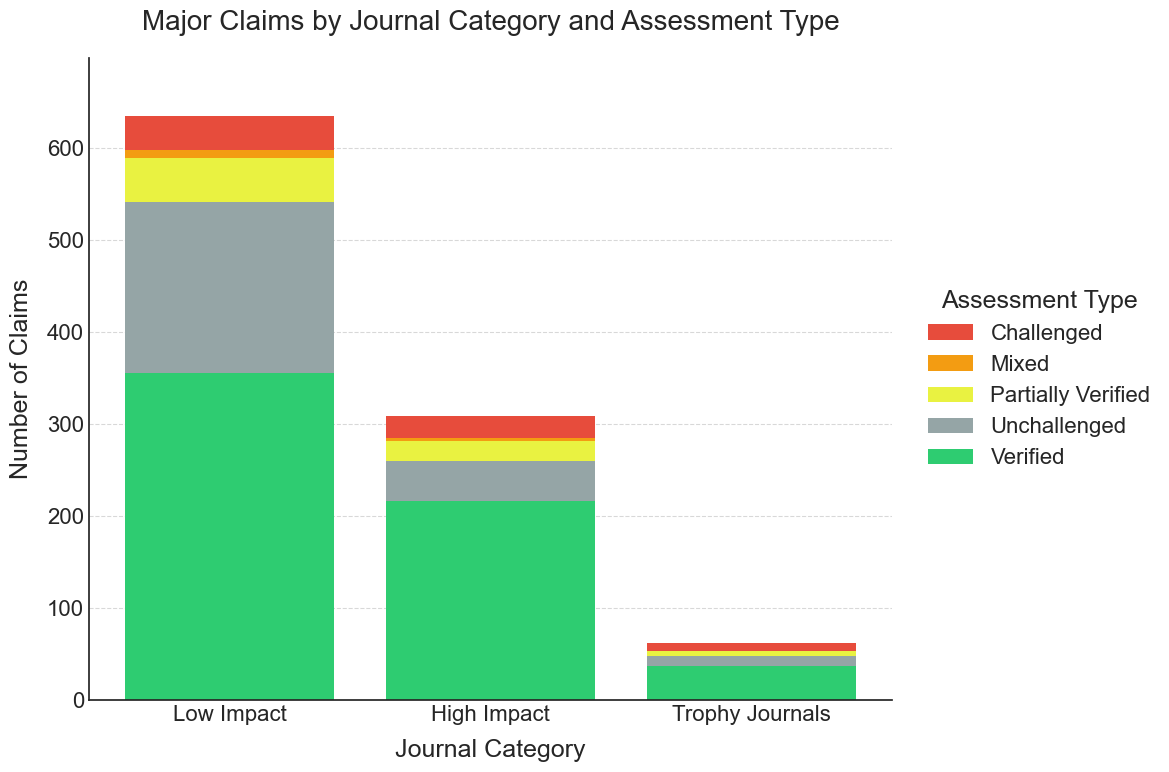

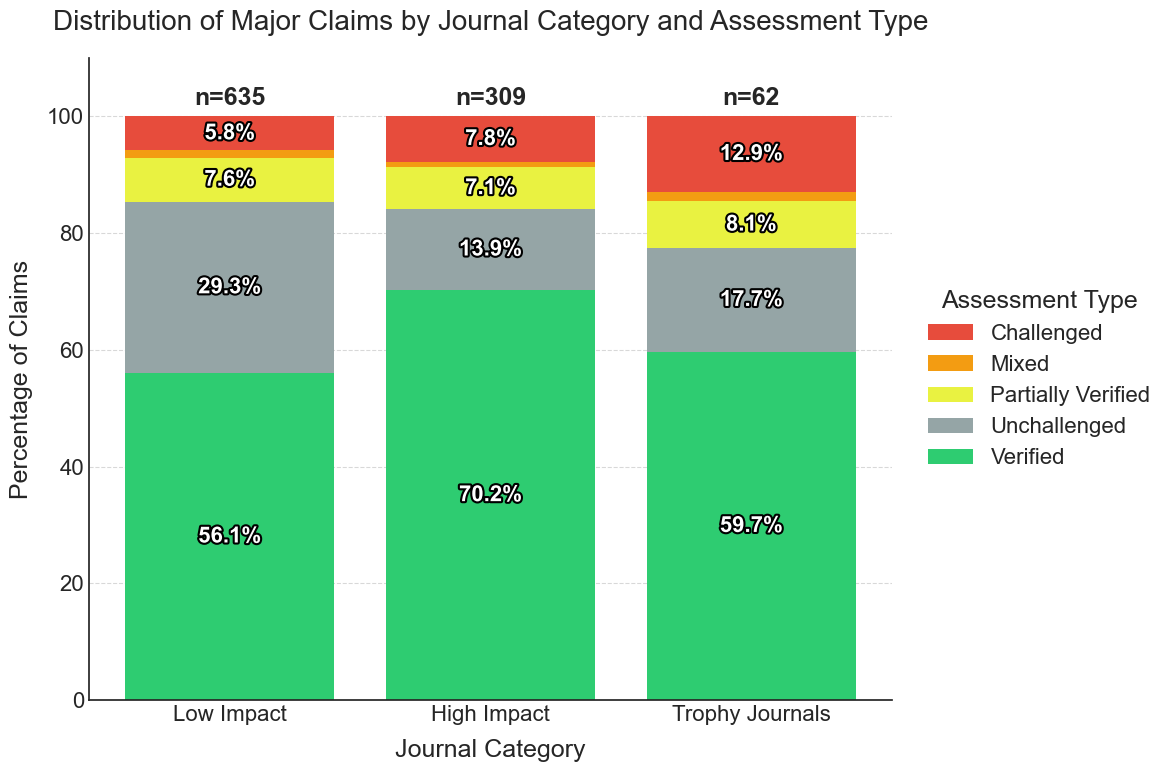

In [11]:
# Generate and save journal category plots
fig1, ax1 = plot_info.create_stacked_bar_plot(major_claims_df, mode='absolute', by_time=False, use_expanded=False)
plt.savefig('figures/fig2A_claims_journal_absolute.png', dpi=300, bbox_inches='tight')

#plt.savefig('figures/fig2_claims_journal_absolute.pdf', bbox_inches='tight')

fig2, ax2 = plot_info.create_stacked_bar_plot(major_claims_df, mode='percentage', by_time=False, use_expanded=False)
plt.savefig('figures/fig2B_claims_journal_percentage.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/fig2_claims_journal_percentage.pdf', bbox_inches='tight')



 ### Time Period Analysis

Using 1006 of 1006 rows


/Users/chadi/Research/drosophila-reproducibility/plot_info.py:385: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom_pos = category_positions[std_cat]['bottom'][i]
/Users/chadi/Research/drosophila-reproducibility/plot_info.py:386: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  height = category_positions[std_cat]['height'][i]
/Users/chadi/Research/drosophila-reproducibility/plot_info.py:424: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

Using 1006 of 1006 rows


/Users/chadi/Research/drosophila-reproducibility/plot_info.py:385: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom_pos = category_positions[std_cat]['bottom'][i]
/Users/chadi/Research/drosophila-reproducibility/plot_info.py:386: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  height = category_positions[std_cat]['height'][i]
/Users/chadi/Research/drosophila-reproducibility/plot_info.py:424: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

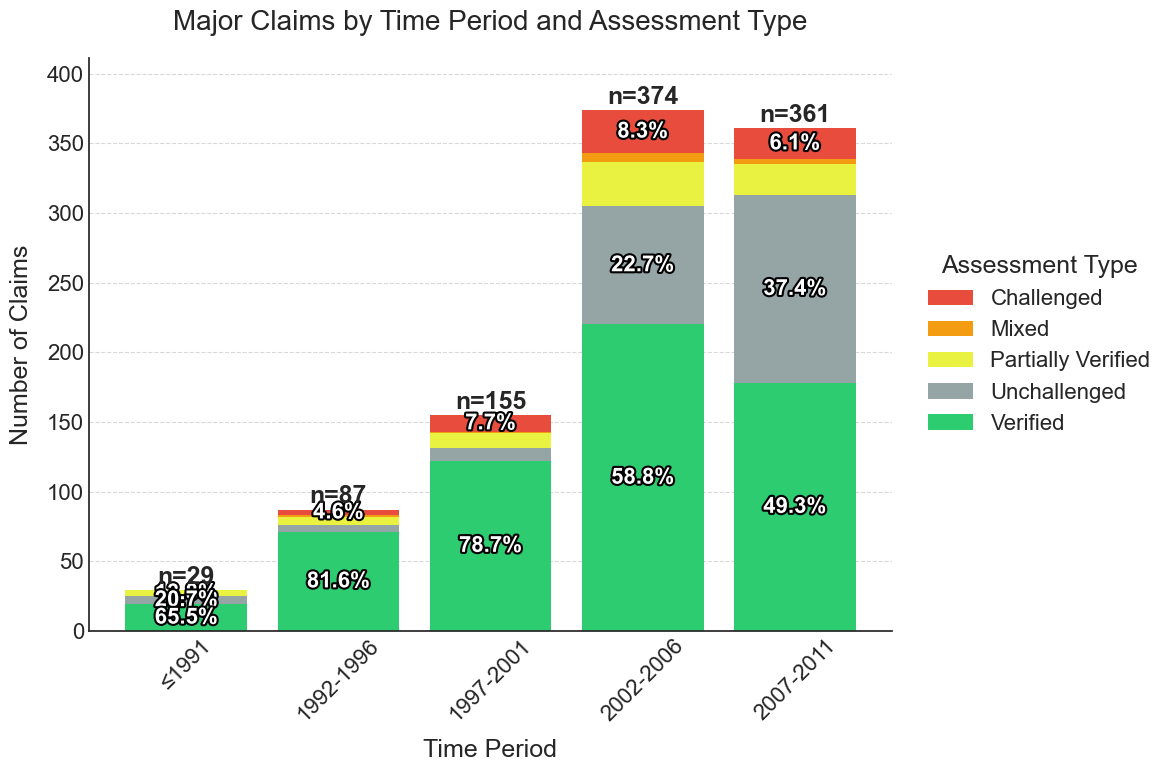

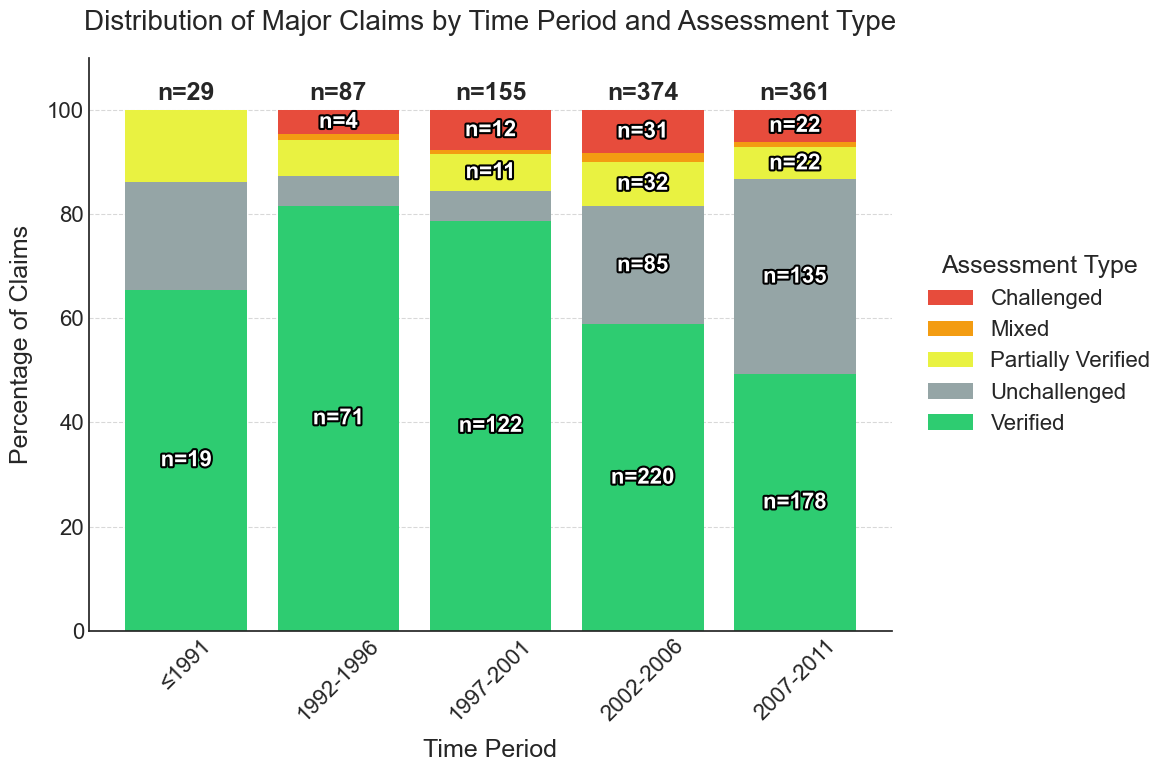

In [12]:
# Generate and save time period plots
fig3, ax3 = plot_info.create_stacked_bar_plot(major_claims_df, mode='absolute', by_time=True)
plt.savefig('figures/fig3A_claims_time_absolute.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/claims_time_absolute.pdf', bbox_inches='tight')

fig4, ax4 = plot_info.create_stacked_bar_plot(major_claims_df, mode='percentage', by_time=True)
plt.savefig('figures/fig3B_claims_time_percentage.png', dpi=300, bbox_inches='tight')
#plt.savefig('figures/claims_time_percentage.pdf', bbox_inches='tight')


 ### Trophy Journals Analysis

 ## Figure 1 Sankey Diagra,

In [13]:
# Create Sankey diagram
to_plot = major_claims_df[["assertion_type", "label", "assessment_type", "rank_assessment_type"]]
fig = plot_info.create_sankey_diagram(to_plot)
fig.show()
fig.write_html('figures/fig1_claims_sankey.html')

In [14]:
major_claims_df

,id,content,article_id,rank,pmid,authors_txt,title,pmid_article,volume,issue,...,last_author_extracted,primary_affiliation,country,assertion_type,label,is_assessed,assessment_type,rank_assessment_type,journal_category,assessment_group
8,577,#gene:FBgn0000279 is...,3103.0,2,NaN,Tryselius Y;Samakovl...,"CecC, a cecropin gen...",1740152.0,204,1,...,Hultmark D,Department of Microb...,Sweden,major_claim,Major claim,True,Verified,1.0,Low Impact,Verified
30,5845,Hemocyte proliferati...,2204.0,3,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
31,5841,The Ras/MAPK pathway...,2204.0,1,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
37,5843,The JAK/STAT and JNK...,2204.0,2,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,...,Hultmark D,Umeå Centre for Mole...,Sweden,major_claim,Major claim,True,Verified,1.0,High Impact,Verified
110,545,#gene:FBgn0035976 fu...,2520.0,2,NaN,Gottar M;Gobert V;Mi...,The Drosophila immun...,11912488.0,416,6881,...,Royet J,UPR 9022 du Centre N...,France,major_claim,Major claim,True,Verified,1.0,Trophy Journals,Verified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13261,9082,Ehrlichia chaffeensi...,1593.0,1,NaN,Luce-Fedrow A;Von Oh...,Ehrlichia chaffeensi...,19687202.0,77,11,...,Chapes SK,Kansas State Univers...,USA,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0,Low Impact,Unchallenged
13264,9728,B. bassiana inhibits...,1532.0,2,NaN,Matskevich AA;Quinti...,The Drosophila PRR G...,20201042.0,40,5,...,Ferrandon D,Equipe Fondation Rec...,France,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0,Low Impact,Unchallenged
13270,1769,A polyclonal antibod...,3004.0,2,NaN,Georgel P;Kappler C;...,Drosophila immunity....,7537872.0,23,7,...,Hoffmann JA,Institut de Biologie...,France,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0,High Impact,Unchallenged
13273,2906,A pathway in additio...,2874.0,3,NaN,Wu LP;Anderson KV,Regulated nuclear im...,9510254.0,392,6671,...,Anderson KV,Molecular Biology Pr...,USA,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0,Trophy Journals,Unchallenged


In [15]:
assessment_columns = plot_info.assessment_columns

def create_author_metric(author_claims):
    # Create base aggregation with name, counts, and article counts
    author_base = major_claims_df.groupby('country').agg(**{
        "Major claims":('id', 'count'),
        "Articles":('article_id', 'nunique')
        }
    )

    # Create a cross-tabulation of first_author_key and assessment_type_grouped
    assessment_counts = pd.crosstab(
        major_claims_df['country'], 
        major_claims_df['assessment_type_grouped']
    )

    # Make sure all assessment columns exist (some might be missing if no authors had that type)
    for col in assessment_columns:
        if col not in assessment_counts.columns:
            assessment_counts[col] = 0

    # Combine the base metrics with assessment counts
    author_metrics = pd.concat([author_base, assessment_counts], axis=1)


    for col in assessment_columns:
        author_metrics[f'{col} prop'] = author_metrics[col] / author_metrics['Major claims']

    author_metrics = author_metrics.reset_index()
    return author_metrics



# Map assessment types to standardized categories
major_claims_df['assessment_type_grouped'] = major_claims_df['assessment_type'].apply(plot_info.group_assessment)


country_metrics = create_author_metric(major_claims_df)
country_metrics

/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_12382/130404903.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,Major claims,Articles,Challenged,Mixed,Partially Verified,Unchallenged,Verified,Unchallenged prop,Verified prop,Partially Verified prop,Mixed prop,Challenged prop
0,Belgium,10,6,0,0,3,3,4,0.300000,0.400000,0.300000,0.000000,0.000000
1,Canada,15,7,0,0,1,9,5,0.600000,0.333333,0.066667,0.000000,0.000000
2,China,25,12,0,0,3,11,11,0.440000,0.440000,0.120000,0.000000,0.000000
3,Czech Republic,2,1,0,0,0,1,1,0.500000,0.500000,0.000000,0.000000,0.000000
4,Finland,17,6,0,0,2,6,9,0.352941,0.529412,0.117647,0.000000,0.000000
5,France,237,88,8,1,17,24,187,0.101266,0.789030,0.071730,0.004219,0.033755
6,Germany,20,8,0,0,0,6,14,0.300000,0.700000,0.000000,0.000000,0.000000
7,Greece,3,1,0,1,0,1,1,0.333333,0.333333,0.000000,0.333333,0.000000
8,Hungary,11,5,0,0,4,1,6,0.090909,0.545455,0.363636,0.000000,0.000000
9,Israel,4,2,0,0,0,3,1,0.750000,0.250000,0.000000,0.000000,0.000000


In [16]:
to_plot = country_metrics

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl

# Set style parameters
plt.style.use('seaborn-v0_8-white')
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Set figure DPI for publication quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Custom colors for categories
ASSESSMENT_COLORS = {
    'Challenged': '#e74c3c',       # Red
    'Mixed': '#f39c12',            # Orange
    'Unchallenged': '#95a5a6',     # Gray
    'Partially Verified': '#f1c40f', # Yellow
    'Verified': '#2ecc71'          # Green
}

def create_simple_horizontal_country_chart(
    df,
    country_col='Country',
    var_to_plot='Challenged_prop',
    min_claims=5,
    sort_by_value=True,
    title=None,
    x_label=None,
    annotate_counts=True,
    fig_size=(12, 8)
):
    """
    Create a simple horizontal bar chart showing a variable by country.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe with country-level data
    country_col : str, default='Country'
        Column name for country
    var_to_plot : str, default='Challenged_prop'
        Column to plot (e.g., 'Challenged_prop', 'Verified_prop')
    min_claims : int, default=5
        Minimum number of claims for a country to be included
    sort_by_value : bool, default=True
        If True, sort countries by the value being plotted
    title : str, optional
        Plot title
    x_label : str, optional
        X-axis label
    annotate_counts : bool, default=True
        Whether to add count annotations to bars
    fig_size : tuple, default=(12, 8)
        Figure size
        
    Returns:
    --------
    fig, ax : matplotlib Figure and Axes objects
    """
    # Filter data
    filtered_df = df[df['Major claims'] >= min_claims].copy()
    
    # Determine if it's a percentage variable
    is_percent = '_prop' in var_to_plot
    
    # Aggregate data by country
    if is_percent:
        # For proportion variables, we need to calculate weighted average
        num_var = var_to_plot.replace('_prop', '')
        claims_by_country = filtered_df.groupby(country_col)['Major claims'].sum()
        counts_by_country = filtered_df.groupby(country_col)[num_var].sum()
        
        country_data = pd.DataFrame({
            'Major claims': claims_by_country,
            var_to_plot: counts_by_country / claims_by_country
        }).reset_index()
    else:
        # For count variables, we can just sum
        country_data = filtered_df.groupby(country_col).agg({
            var_to_plot: 'sum',
            'Major claims': 'sum'
        }).reset_index()
    
    # Sort data if requested
    if sort_by_value:
        country_data = country_data.sort_values(by=var_to_plot, ascending=False)
    else:
        country_data = country_data.sort_values(by=country_col)
    
    # Adjust figure height based on number of countries
    country_count = len(country_data)
    if country_count < 5:
        fig_size = (fig_size[0], max(4, country_count * 0.8))
    elif country_count > 12:
        fig_size = (fig_size[0], min(16, country_count * 0.6))
    
    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Get color based on variable
    if 'Challenged' in var_to_plot:
        color = ASSESSMENT_COLORS['Challenged']
    elif 'Verified' in var_to_plot:
        color = ASSESSMENT_COLORS['Verified']
    elif 'Unchallenged' in var_to_plot:
        color = ASSESSMENT_COLORS['Unchallenged']
    elif 'Mixed' in var_to_plot:
        color = ASSESSMENT_COLORS['Mixed']
    elif 'Partially Verified' in var_to_plot:
        color = ASSESSMENT_COLORS['Partially Verified']
    else:
        color = '#3498db'  # Default blue
    
    # Plot horizontal bars
    bars = ax.barh(
        country_data[country_col],
        country_data[var_to_plot],
        color=color,
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )
    
    # Add value labels to bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        
        # Format label based on whether it's a percentage
        if is_percent:
            label = f"{width:.1%}"
        else:
            label = f"{width:.0f}"
        
        ax.text(
            width/2,
            bar.get_y() + bar.get_height()/2,
            label,
            ha='center', va='center',
            color='white', fontweight='bold', fontsize=12
        )
    
    # Add count annotations if requested
    if annotate_counts:
        for i, (_, row) in enumerate(country_data.iterrows()):
            ax.text(
                0.01,
                i,
                f"n={int(row['Major claims'])}",
                va='center', ha='left',
                fontsize=10, color='black',
                transform=ax.get_yaxis_transform()
            )
    
    # Format x-axis as percentage if appropriate
    if is_percent:
        ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Add global mean line
    mean_val = country_data[var_to_plot].mean()
    if is_percent:
        mean_label = f"Mean: {mean_val:.1%}"
    else:
        mean_label = f"Mean: {mean_val:.1f}"
    
    ax.axvline(
        mean_val,
        color='black',
        linestyle='--',
        alpha=0.7,
        linewidth=1.5,
        label=mean_label
    )
    
    # Set labels and title
    if x_label:
        ax.set_xlabel(x_label, fontweight='bold')
    else:
        # Generate a reasonable x-label from the variable name
        if is_percent:
            x_label = f"Proportion of {var_to_plot.replace('_prop', '')} Claims"
        else:
            x_label = f"Number of {var_to_plot} Claims"
        ax.set_xlabel(x_label, fontweight='bold')
    
    ax.set_ylabel('Country', fontweight='bold')
    
    if title:
        ax.set_title(title, fontweight='bold', pad=20)
    else:
        if is_percent:
            title = f"Proportion of {var_to_plot.replace('_prop', '')} Claims by Country"
        else:
            title = f"{var_to_plot} Claims by Country"
        ax.set_title(title, fontweight='bold', pad=20)
    
    # Customize grid
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(loc='best', frameon=True, framealpha=0.9, edgecolor='lightgray')
    
    # Tight layout
    plt.tight_layout()
    
    return fig, ax

def create_country_comparison(
    df,
    country_col='Country',
    min_claims=5,
    title="Reproducibility Metrics by Country",
    fig_size=(16, 10)
):
    """
    Create a set of simple horizontal bar charts for comparing different reproducibility
    metrics across countries.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe with country-level data
    country_col : str, default='Country'
        Column name for country
    min_claims : int, default=5
        Minimum number of claims for a country to be included
    title : str, optional
        Main title for the figure
    fig_size : tuple, default=(16, 10)
        Figure size
        
    Returns:
    --------
    fig : matplotlib Figure object
    """
    # Filter data
    filtered_df = df[df['Major claims'] >= min_claims].copy()
    
    # Calculate proportions if not already present
    if 'Challenged_prop' not in filtered_df.columns:
        # Group by country to calculate proportions
        country_agg = filtered_df.groupby(country_col).agg({
            'Challenged': 'sum',
            'Verified': 'sum',
            'Unchallenged': 'sum',
            'Major claims': 'sum'
        }).reset_index()
        
        # Calculate proportions
        country_agg['Challenged_prop'] = country_agg['Challenged'] / country_agg['Major claims']
        country_agg['Verified_prop'] = country_agg['Verified'] / country_agg['Major claims']
        country_agg['Unchallenged_prop'] = country_agg['Unchallenged'] / country_agg['Major claims']
    else:
        # Already have proportions
        country_agg = filtered_df.groupby(country_col).agg({
            'Challenged_prop': 'mean',
            'Verified_prop': 'mean',
            'Unchallenged_prop': 'mean',
            'Major claims': 'sum'
        }).reset_index()
    
    # Sort countries by challenged proportion
    sorted_countries = country_agg.sort_values('Challenged_prop', ascending=False)[country_col].tolist()
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=fig_size)
    
    # Plot challenged proportion
    bars1 = axes[0].barh(
        country_agg[country_col],
        country_agg['Challenged_prop'],
        color=ASSESSMENT_COLORS['Challenged'],
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )
    
    # Plot verified proportion
    bars2 = axes[1].barh(
        country_agg[country_col],
        country_agg['Verified_prop'],
        color=ASSESSMENT_COLORS['Verified'],
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )
    
    # Plot unchallenged proportion
    bars3 = axes[2].barh(
        country_agg[country_col],
        country_agg['Unchallenged_prop'],
        color=ASSESSMENT_COLORS['Unchallenged'],
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )
    
    # Add value labels and customize each subplot
    for ax_idx, (bars, metric, title_text) in enumerate(zip(
        [bars1, bars2, bars3],
        ['Challenged_prop', 'Verified_prop', 'Unchallenged_prop'],
        ['Challenged Claims', 'Verified Claims', 'Unchallenged Claims']
    )):
        ax = axes[ax_idx]
        
        # Add bar labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            label = f"{width:.1%}"
            ax.text(
                width/2,
                bar.get_y() + bar.get_height()/2,
                label,
                ha='center', va='center',
                color='white', fontweight='bold', fontsize=12
            )
        
        # Add count annotations
        for i, (_, row) in enumerate(country_agg.iterrows()):
            ax.text(
                0.01,
                i,
                f"n={int(row['Major claims'])}",
                va='center', ha='left',
                fontsize=9, color='black',
                transform=ax.get_yaxis_transform()
            )
        
        # Add mean line
        mean_val = country_agg[metric].mean()
        ax.axvline(
            mean_val,
            color='black',
            linestyle='--',
            alpha=0.7,
            linewidth=1.5,
            label=f"Mean: {mean_val:.1%}"
        )
        
        # Format axis
        ax.xaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_title(f"Proportion of {title_text} by Country", fontweight='bold')
        
        # Only add x-label to bottom plot
        if ax_idx == 2:
            ax.set_xlabel('Proportion of Claims', fontweight='bold')
        
        # Only add y-label to middle plot
        if ax_idx == 1:
            ax.set_ylabel('Country', fontweight='bold')
        
        # Customize grid and spines
        ax.grid(axis='x', linestyle='--', alpha=0.3)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend
        ax.legend(loc='best', frameon=True, framealpha=0.9, edgecolor='lightgray')
    
    # Ensure all plots show the same countries in the same order
    for ax in axes:
        ax.set_yticks(range(len(sorted_countries)))
        ax.set_yticklabels(sorted_countries)
    
    # Add main title
    fig.suptitle(title, fontsize=BIGGER_SIZE+2, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3)
    
    return fig, axes

# Example usage for simple chart:
fig, ax = create_simple_horizontal_country_chart(
    df=to_plot,
    var_to_plot='Challenged_prop',
    min_claims=5,
    title='Proportion of Challenged Claims by Country',
    x_label='Proportion of Challenged Claims'
)

# Example usage for multi-metric comparison:
fig, axes = create_country_comparison(
    df=to_plot,
    min_claims=5,
    title="Reproducibility Metrics by Country"
)

# plt.savefig('country_comparison.png', dpi=300, bbox_inches='tight')

KeyError: 'Country'

,assertion_type,label,assessment_type,rank_assessment_type
8,major_claim,Major claim,Verified,1.0
30,major_claim,Major claim,Verified,1.0
31,major_claim,Major claim,Verified,1.0
37,major_claim,Major claim,Verified,1.0
110,major_claim,Major claim,Verified,1.0
...,...,...,...,...
13261,major_claim,Major claim,"Unchallenged, logically consistent",6.0
13264,major_claim,Major claim,"Unchallenged, logically consistent",6.0
13270,major_claim,Major claim,"Unchallenged, logically inconsistent",7.0
13273,major_claim,Major claim,"Unchallenged, logically inconsistent",7.0


In [ ]:
major_claims_df.columns

Index(['content', 'article_id', 'rank', 'pmid', 'authors_txt', 'title',
       'pmid_article', 'volume', 'issue', 'abstract', 'year', 'journal_name',
       'impact_factor', 'first_author_extracted', 'last_author_extracted',
       'primary_affiliation', 'assertion_type', 'label', 'is_assessed',
       'assessment_type', 'rank_assessment_type', 'journal_category',
       'assessment_group'],
      dtype='object')

In [ ]:
def create_author_metric(author_claims):
    # Create base aggregation with name, counts, and article counts
    author_base = major_claims_df.groupby('last_author_key').agg(**{
        "Name":('Name', 'first'),
        "Major claims":('id', 'count'),
        "Articles":('article_id', 'nunique')
        }
    )

    # Create a cross-tabulation of first_author_key and assessment_type_grouped
    assessment_counts = pd.crosstab(
        major_claims_df['last_author_key'], 
        major_claims_df['assessment_type_grouped']
    )

    # Make sure all assessment columns exist (some might be missing if no authors had that type)
    for col in major_claims_df:
        if col not in assessment_counts.columns:
            assessment_counts[col] = 0

    # Combine the base metrics with assessment counts
    author_metrics = pd.concat([author_base, assessment_counts], axis=1)


    for col in major_claims_df:
        author_metrics[f'{col} prop'] = author_metrics[col] / author_metrics['Major claims']

    author_metrics = author_metrics.reset_index()

    return author_metrics

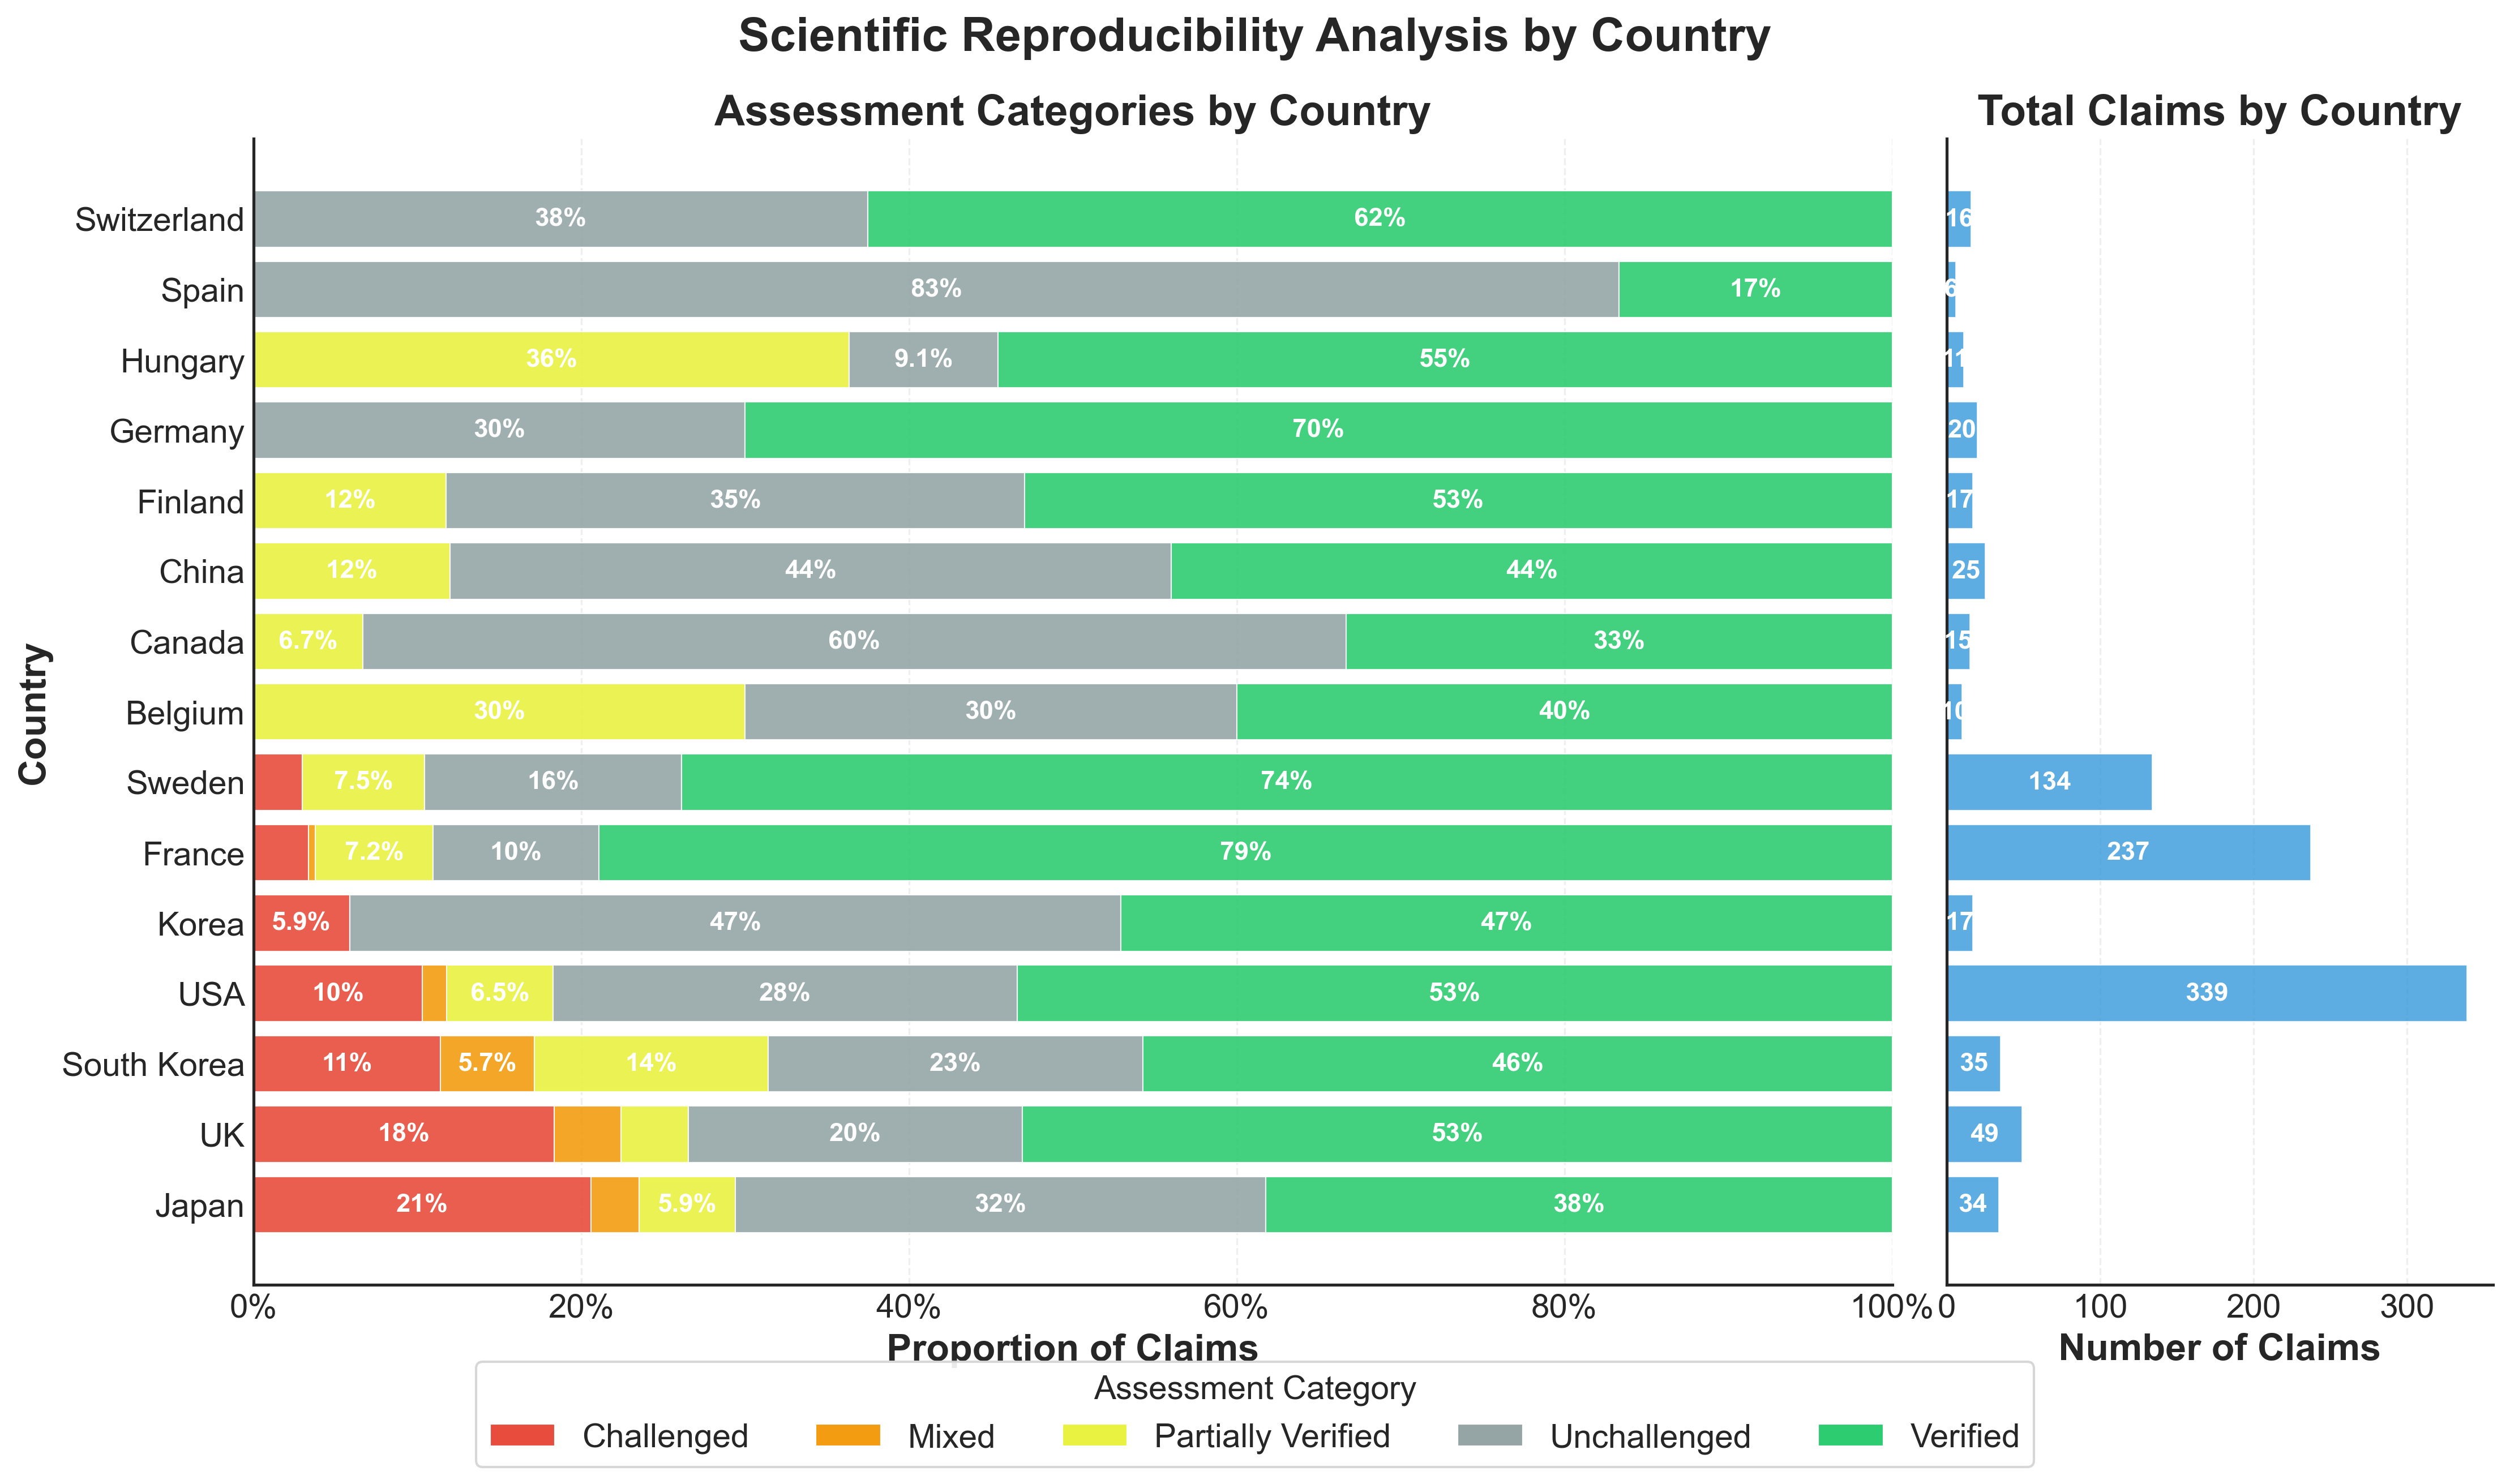

In [ ]:
# Import necessary modules
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.pyplot as plt

# Define colors for categories
ASSESSMENT_COLORS = plot_info.ASSESSMENT_COLORS

# Define the category order for consistent stacking
ASSESSMENT_ORDER = plot_info.ASSESSMENT_ORDER


def create_two_panel_country_chart(
    df,
    country_col='country',
    min_claims=0,
    sort_by='Challenged_prop',
    title="Reproducibility Analysis by Country",
    fig_size=(15, 10)
):
    """
    Create a two-panel chart with stacked proportions and a separate bar chart
    for number of claims by country.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe with country-level data
    country_col : str, default='country'
        Column name for country
    min_claims : int, default=5
        Minimum number of claims for a country to be included
    sort_by : str, default='Challenged_prop'
        How to sort countries
    title : str, default="Reproducibility Analysis by Country"
        Main title for the figure
    fig_size : tuple, default=(15, 10)
        Figure size
        
    Returns:
    --------
    fig : matplotlib Figure object
    """
    # Filter data
    filtered_df = df[df['Major claims'] >= min_claims].copy()
    
    # Aggregate data by country
    categories = ['Challenged', 'Mixed', 'Unchallenged', 'Partially Verified', 'Verified']
    
    # Group by country
    country_sums = filtered_df.groupby(country_col)[categories + ['Major claims', 'Articles']].sum().reset_index()
    
    # Calculate proportions
    for cat in categories:
        country_sums[f'{cat}_prop'] = country_sums[cat] / country_sums['Major claims']
    
    # Sort countries based on the specified criterion
    if sort_by in country_sums.columns:
        country_sums = country_sums.sort_values(sort_by, ascending=False)
    
    # Get list of countries in proper order
    countries = country_sums[country_col].tolist()
    
    # Adjust figure height based on number of countries
    country_count = len(countries)
    if country_count < 5:
        fig_size = (fig_size[0], max(4, country_count * 0.8))
    elif country_count > 12:
        fig_size = (fig_size[0], min(16, country_count * 0.6))
    
    # Create figure with two panels
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size, gridspec_kw={'width_ratios': [3, 1]})
    
    # Panel 1: Stacked proportions
    y_pos = np.arange(len(countries))
    lefts = np.zeros(len(countries))
    
    # Create stacked bars
    for category in ASSESSMENT_ORDER:
        prop_col = f'{category}_prop'
        widths = country_sums[prop_col].values
        
        # Plot this category as a segment in the stacked bar
        bar = ax1.barh(
            y_pos,
            widths,
            left=lefts,
            color=ASSESSMENT_COLORS[category],
            label=category,
            edgecolor='white',
            linewidth=0.5,
            alpha=0.9
        )
        
        # Update left positions for next category
        lefts += widths
        
        # Add text labels to segments that are large enough
        for i, width in enumerate(widths):
            if width > 0.05:  # Only label segments that are at least 5%
                # Position text in center of segment
                x_pos = lefts[i] - width/2
                
                # Add percentage label
                ax1.text(
                    x_pos,
                    y_pos[i],
                    f'{width:.0%}' if width >= 0.1 else f'{width:.1%}',
                    ha='center',
                    va='center',
                    color='white',
                    fontweight='bold',
                    fontsize=11
                )
    
    # Set country names on y-axis
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(countries)
    
    # Set axis labels and title
    ax1.set_xlabel('Proportion of Claims', fontweight='bold')
    ax1.set_ylabel('Country', fontweight='bold')
    ax1.set_title('Assessment Categories by Country', fontweight='bold')
    
    # Format x-axis as percentage
    ax1.xaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Set x-axis limit
    ax1.set_xlim(0, 1.0)
    
    # Add grid
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    ax1.set_axisbelow(True)
    
    # Remove top and right spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Panel 2: Number of claims bar chart
    bars = ax2.barh(
        y_pos,
        country_sums['Major claims'],
        color='#3498db',  # Blue
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )
    
    # Add value labels to bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(
            width/2,
            bar.get_y() + bar.get_height()/2,
            f"{int(width)}",
            ha='center',
            va='center',
            color='white',
            fontweight='bold',
            fontsize=11
        )
    
    # Set axis labels and title
    ax2.set_xlabel('Number of Claims', fontweight='bold')
    ax2.set_title('Total Claims by Country', fontweight='bold')
    
    # Hide y-axis labels (shared with first panel)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([])
    
    # Add grid
    ax2.grid(axis='x', linestyle='--', alpha=0.3)
    ax2.set_axisbelow(True)
    
    # Remove top and right spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add legend below the figure
    handles = [Patch(facecolor=ASSESSMENT_COLORS[cat], edgecolor='white', label=cat) for cat in ASSESSMENT_ORDER]
    fig.legend(
        handles=handles,
        loc='lower center',
        ncol=len(ASSESSMENT_ORDER),
        frameon=True,
        framealpha=0.9,
        edgecolor='lightgray',
        title="Assessment Category",
        bbox_to_anchor=(0.5, 0.02)  # FIXED: Adjusted position
    )
    
    # Add main title
    fig.suptitle(title, fontsize=BIGGER_SIZE+2, fontweight='bold', y=0.98)
    
    # FIXED: Better layout adjustment
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, top=0.90, wspace=0.05)
    
    return fig, (ax1, ax2)


# Example usage for two-panel chart:
fig, (ax1, ax2) = create_two_panel_country_chart(
    df=to_plot,
    min_claims=5,
    sort_by='Challenged_prop',
    title="Scientific Reproducibility Analysis by Country"
)
# TODO: sort then on opartially verified.
plt.savefig('figures/figXC_country.png', dpi=300, bbox_inches='tight')